<a href="https://colab.research.google.com/github/WoojinJeonkr/DeepLearning/blob/main/Unbalanced_Data_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 불균형 데이터 분류
- 한 클래스의 예시의 수가 다른 클래스보다 훨씬 많은 매우 불균형적인 데이터세트 분류하기



## 01. 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 데이터 처리 및 탐색
- 사용 데이터: Kaggle 신용 카드 부정 행위 데이터 세트

In [2]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 02. 클래스 레이블 불균형 검사

In [4]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



## 03. 데이터 정리, 분할 및 정규화

In [6]:
cleaned_df = raw_df.copy()

# Time column 삭제
cleaned_df.pop('Time')

eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount')+eps)

In [7]:
# 데이터세트 분할
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
# 입력 특성 정규화
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


## 04. 데이터 분포 살펴보기

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


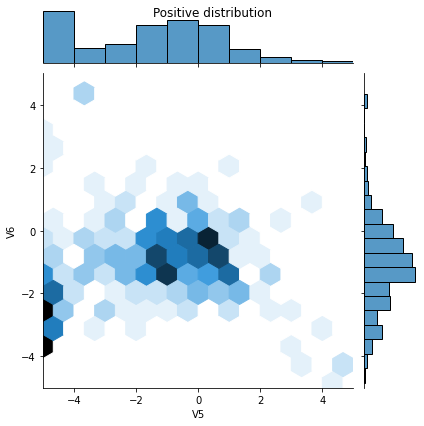

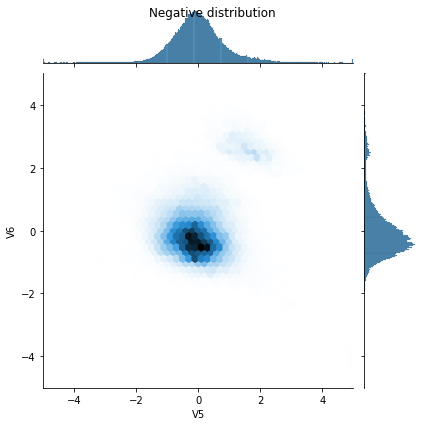

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [10]:
# 대부분 +/- 2 범위에 집중
# 양의 예에는 극단적 값의 비율이 훨씬 높음

## 05. 모델 및 metrics 정의

In [11]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [12]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## 06. 모델 구축하기

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
model = make_model()
model.summary() # 모델 요약

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 모델 테스트
model.predict(train_features[:10])

array([[0.73736113],
       [0.85871375],
       [0.89980626],
       [0.9401328 ],
       [0.9712709 ],
       [0.73797935],
       [0.8436279 ],
       [0.85367954],
       [0.8758584 ],
       [0.61697793]], dtype=float32)

## 07. 초기 바이어스 설정

In [16]:
# 기존 바이어스 초기화 사용
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.7003


In [17]:
# 바이어스 설정
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00175914],
       [0.00204498],
       [0.00618708],
       [0.00251561],
       [0.00399742],
       [0.00107604],
       [0.00199157],
       [0.00215861],
       [0.00397512],
       [0.00289857]], dtype=float32)

In [19]:
# 초기화를 통한 초기 손실 계산
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0124


## 08. 초기 가중치 체크 포인트

In [20]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [21]:
# 바이어스 초기화가 도움이 되었는지 확인하기
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [28]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color='red', label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
          color='blue', label='Val '+label,
          linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend()

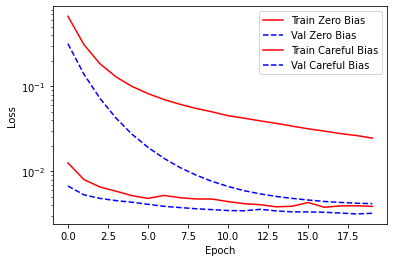

In [29]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## 09. 모델 학습

In [30]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 5s 19ms/step - loss: 0.0126 - tp: 138.0000 - fp: 114.0000 - tn: 227321.0000 - fn: 272.0000 - accuracy: 0.9983 - precision: 0.5476 - recall: 0.3366 - auc: 0.7831 - prc: 0.2909 - val_loss: 0.0067 - val_tp: 21.0000 - val_fp: 6.0000 - val_tn: 45486.0000 - val_fn: 56.0000 - val_accuracy: 0.9986 - val_precision: 0.7778 - val_recall: 0.2727 - val_auc: 0.8754 - val_prc: 0.5774
Epoch 2/100
90/90 [==============================] - 0s 5ms/step - loss: 0.0079 - tp: 124.0000 - fp: 41.0000 - tn: 181902.0000 - fn: 209.0000 - accuracy: 0.9986 - precision: 0.7515 - recall: 0.3724 - auc: 0.8628 - prc: 0.4502 - val_loss: 0.0053 - val_tp: 38.0000 - val_fp: 8.0000 - val_tn: 45484.0000 - val_fn: 39.0000 - val_accuracy: 0.9990 - val_precision: 0.8261 - val_recall: 0.4935 - val_auc: 0.8827 - val_prc: 0.5851
Epoch 3/100
90/90 [==============================] - 0s 4ms/step - loss: 0.0062 - tp: 172.0000 - fp: 27.0000 - tn: 181916.0000 - fn: 161.0000 - accuracy

## 10. 학습 이력 확인

In [32]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color='purple', label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color='purple', linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

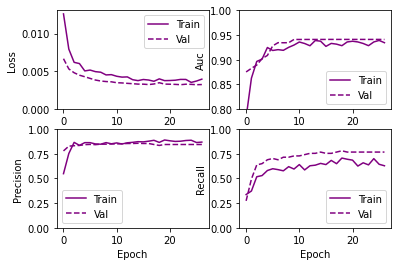

In [33]:
plot_metrics(baseline_history)

## 11. 메트릭 평가
- 혼동행렬을 이용해 실제 레이블과 예측 레이블 요약
- X축: 예측 레이블, Y축: 실제 레이블

In [34]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [35]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.003536829026415944
tp :  55.0
fp :  10.0
tn :  56870.0
fn :  27.0
accuracy :  0.9993504285812378
precision :  0.8461538553237915
recall :  0.6707317233085632
auc :  0.9081417322158813
prc :  0.7314957976341248

Legitimate Transactions Detected (True Negatives):  56870
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  27
Fraudulent Transactions Detected (True Positives):  55
Total Fraudulent Transactions:  82


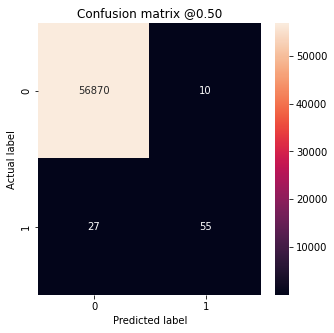

In [36]:
# 테스트 데이터세트에서 모델을 평가하고 위에서 생성한 메트릭 결과 표시
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

## 12. ROC 플로팅

In [37]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

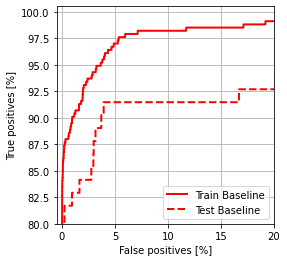

In [40]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color='red')
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color='red', linestyle='--')
plt.legend(loc='lower right')

## 13. AUPRC 플로팅

In [41]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

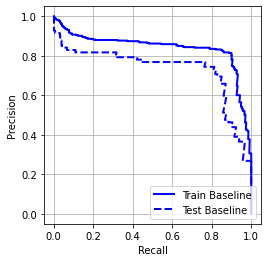

In [42]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color='blue')
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color='blue', linestyle='--')
plt.legend(loc='lower right')

## 14. 클래스 가중치 계산

In [43]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


## 15. 클래스 가중치로 모델 교육

In [44]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 7s 29ms/step - loss: 1.6580 - tp: 169.0000 - fp: 487.0000 - tn: 238336.0000 - fn: 246.0000 - accuracy: 0.9969 - precision: 0.2576 - recall: 0.4072 - auc: 0.8123 - prc: 0.2332 - val_loss: 0.0115 - val_tp: 44.0000 - val_fp: 38.0000 - val_tn: 45454.0000 - val_fn: 33.0000 - val_accuracy: 0.9984 - val_precision: 0.5366 - val_recall: 0.5714 - val_auc: 0.8780 - val_prc: 0.4496
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.9352 - tp: 188.0000 - fp: 1011.0000 - tn: 180932.0000 - fn: 145.0000 - accuracy: 0.9937 - precision: 0.1568 - recall: 0.5646 - auc: 0.8742 - prc: 0.2570 - val_loss: 0.0166 - val_tp: 59.0000 - val_fp: 82.0000 - val_tn: 45410.0000 - val_fn: 18.0000 - val_accuracy: 0.9978 - val_precision: 0.4184 - val_recall: 0.7662 - val_auc: 0.9387 - val_prc: 0.5719
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.5619 - tp: 249.0000 - fp: 1517.0000 - tn: 180426.0000 - fn: 84.0000 - ac

## 16. 학습 이력 조회

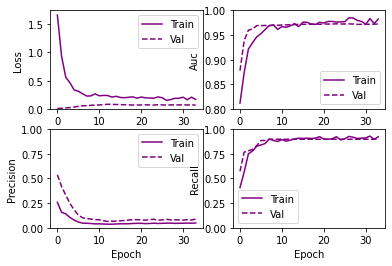

In [45]:
plot_metrics(weighted_history)

## 17. 매트릭 평가

In [46]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.06780388951301575
tp :  71.0
fp :  863.0
tn :  56017.0
fn :  11.0
accuracy :  0.9846564531326294
precision :  0.07601713389158249
recall :  0.8658536672592163
auc :  0.9545950293540955
prc :  0.4959728717803955

Legitimate Transactions Detected (True Negatives):  56017
Legitimate Transactions Incorrectly Detected (False Positives):  863
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  82


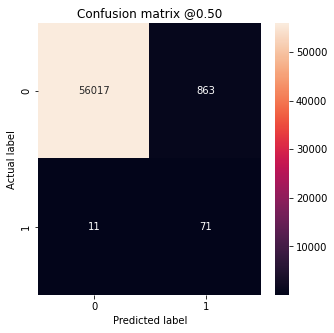

In [47]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

## 18. ROC 플로팅

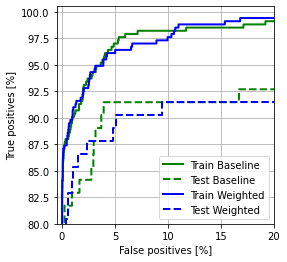

In [48]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color='green')
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color='green', linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color='blue')
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color='blue', linestyle='--')


plt.legend(loc='lower right')

## 19. AUPRC 플로팅

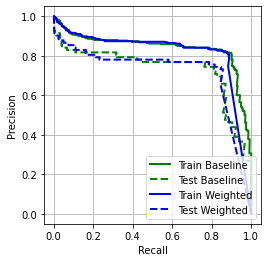

In [49]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color='green')
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color='green', linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color='blue')
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color='blue', linestyle='--')


plt.legend(loc='lower right')

## 20. 오버샘플링

In [50]:
# 데이터 리샘플링
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [51]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181943, 29)

In [52]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363886, 29)

In [53]:
# tf.data 사용
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [54]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 2.31219083e-03  1.45114863e+00 -1.71661032e+00  7.85299829e-01
  2.40283003e+00 -1.34069188e+00  1.74308135e+00 -7.06114787e-01
  8.21577248e-01 -3.10318759e+00  2.01374622e+00 -3.97081720e+00
  1.02922358e+00 -5.00000000e+00 -1.26102426e+00  1.91401620e+00
  5.00000000e+00  3.32010515e+00 -2.75325952e+00 -9.85482237e-03
 -7.80918234e-01 -1.24567000e+00 -6.58321284e-01 -2.26209108e-02
  1.13761155e+00 -1.52436845e+00 -1.11262958e+00 -1.15947668e+00
 -1.45282074e+00]

Label:  1


In [55]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


In [56]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49267578125


In [57]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

## 21. 오버 샘플링된 데이터에 대한 학습

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 24s 69ms/step - loss: 0.3720 - tp: 246965.0000 - fp: 68764.0000 - tn: 272364.0000 - fn: 38213.0000 - accuracy: 0.8292 - precision: 0.7822 - recall: 0.8660 - auc: 0.9317 - prc: 0.9379 - val_loss: 0.1748 - val_tp: 68.0000 - val_fp: 1042.0000 - val_tn: 44450.0000 - val_fn: 9.0000 - val_accuracy: 0.9769 - val_precision: 0.0613 - val_recall: 0.8831 - val_auc: 0.9637 - val_prc: 0.6972
Epoch 2/100
278/278 [==============================] - 17s 61ms/step - loss: 0.1718 - tp: 261215.0000 - fp: 14824.0000 - tn: 269755.0000 - fn: 23550.0000 - accuracy: 0.9326 - precision: 0.9463 - recall: 0.9173 - auc: 0.9812 - prc: 0.9846 - val_loss: 0.0931 - val_tp: 69.0000 - val_fp: 813.0000 - val_tn: 44679.0000 - val_fn: 8.0000 - val_accuracy: 0.9820 - val_precision: 0.0782 - val_recall: 0.8961 - val_auc: 0.9642 - val_prc: 0.7372
Epoch 3/100
278/278 [==============================] - 17s 61ms/step - loss: 0.1323 - tp: 265076.0000 - fp: 10347.0000 - tn: 27

## 22. 교육 이력 확인

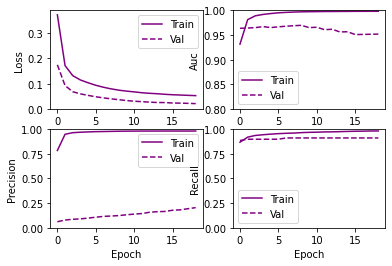

In [59]:
plot_metrics(resampled_history)

## 23. 재교육

In [60]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 6s 143ms/step - loss: 0.7792 - tp: 14236.0000 - fp: 12121.0000 - tn: 53891.0000 - fn: 6281.0000 - accuracy: 0.7873 - precision: 0.5401 - recall: 0.6939 - auc: 0.8935 - prc: 0.7538 - val_loss: 0.8323 - val_tp: 68.0000 - val_fp: 26957.0000 - val_tn: 18535.0000 - val_fn: 9.0000 - val_accuracy: 0.4082 - val_precision: 0.0025 - val_recall: 0.8831 - val_auc: 0.8457 - val_prc: 0.2044
Epoch 2/1000
20/20 [==============================] - 1s 69ms/step - loss: 0.6033 - tp: 16792.0000 - fp: 10538.0000 - tn: 9772.0000 - fn: 3858.0000 - accuracy: 0.6485 - precision: 0.6144 - recall: 0.8132 - auc: 0.8011 - prc: 0.8533 - val_loss: 0.7221 - val_tp: 69.0000 - val_fp: 21232.0000 - val_tn: 24260.0000 - val_fn: 8.0000 - val_accuracy: 0.5339 - val_precision: 0.0032 - val_recall: 0.8961 - val_auc: 0.8907 - val_prc: 0.3308
Epoch 3/1000
20/20 [==============================] - 1s 65ms/step - loss: 0.5163 - tp: 17392.0000 - fp: 9010.0000 - tn: 11499.0000 - 

## 24. 훈련 이력 재확인

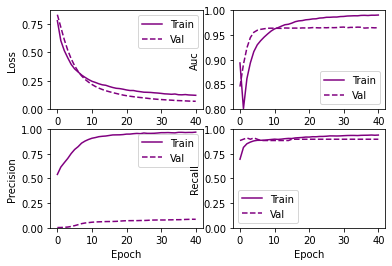

In [61]:
plot_metrics(resampled_history)

## 25. 메트릭 평가

In [62]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.082796111702919
tp :  70.0
fp :  941.0
tn :  55939.0
fn :  12.0
accuracy :  0.9832695722579956
precision :  0.06923837959766388
recall :  0.8536585569381714
auc :  0.9482340812683105
prc :  0.6489150524139404

Legitimate Transactions Detected (True Negatives):  55939
Legitimate Transactions Incorrectly Detected (False Positives):  941
Fraudulent Transactions Missed (False Negatives):  12
Fraudulent Transactions Detected (True Positives):  70
Total Fraudulent Transactions:  82


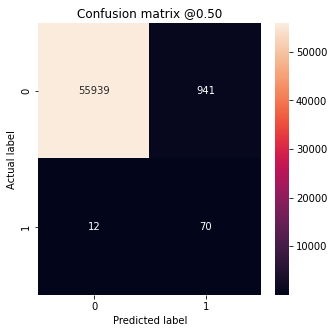

In [63]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

## 26. ROC 플로팅

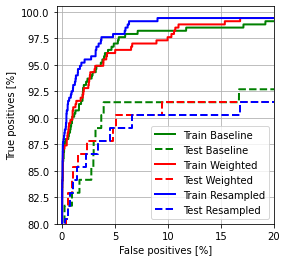

In [64]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color='green')
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color='green', linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color='red')
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color='red', linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color='blue')
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color='blue', linestyle='--')
plt.legend(loc='lower right')

## 27. AUPRC 플로팅

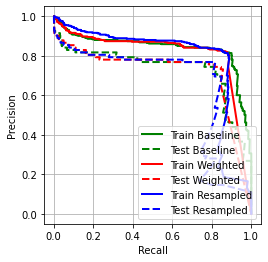

In [66]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color='green')
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color='green', linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color='red')
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color='red', linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color='blue')
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color='blue', linestyle='--')
plt.legend(loc='lower right')